# Superposition by embedding bottleneck

This is an experiment to squash higher-dimensional data into a lower-dimensional embedding space. We'll start with color: RGB values (3 dimensions) ranging from 0..1. If we compress them into a 2D embedding, we should expect to see superposition, with directions interpretable as they would be in a classic color wheel: three primary color directions (RGB) spaced 120° apart.


## Training data

While we describe colors in terms of hue (the color wheel), saturation (color intensity), and value (brightness), RGB values combine these properties in a non-intuitive way.

Primary colors are fully-saturated, and are vectors of length 1:

| Color |  R  |  G  |  B  | Length |
| ----- | :-: | :-: | :-: | :----: |
| red   | $1$ | $0$ | $0$ |  $1$   |
| green | $0$ | $1$ | $0$ |  $1$   |
| blue  | $1$ | $0$ | $1$ |  $1$   |

Secondary colors are also fully-saturated, but have length $\sqrt2$:

| Color   |  R  |  G  |  B  |  Length  |
| ------- | :-: | :-: | :-: | :------: |
| yellow  | $1$ | $1$ | $0$ | $\sqrt2$ |
| cyan    | $0$ | $1$ | $1$ | $\sqrt2$ |
| magenta | $0$ | $0$ | $1$ | $\sqrt2$ |

Whereas grayscale values are fully _desaturated_ (have no defined hue), and have various lengths:

| Color |     R      |     G      |     B      |  Length  |
| ----- | :--------: | :--------: | :--------: | :------: |
| black |    $0$     |    $0$     |    $0$     |   $0$    |
| gray  | $\sqrt{⅓}$ | $\sqrt{⅓}$ | $\sqrt{⅓}$ |   $1$    |
| white |    $1$     |    $1$     |    $1$     | $\sqrt3$ |

We could pick random RGB values, but even if the vectors were normalized, we wouldn't necessarily get data that compresses well to a 2D embedding. So we will use `colorsys` — a builtin Python module that lets us work with perceptual properties. For our superposition experiment, generating colors by varying hue while keeping saturation and value fixed gives us a much more intuitive and evenly distributed set of training examples that isolate the property we're most interested in studying.

Let's do a quick test to see if we can reproduce the primary and secondary RGB values just by varying the hue.


In [1]:
import colorsys
import numpy as np

# Create an array of evenly spaced hues (every 60 degrees)
hues = np.arange(0, 360, 60, dtype=float)

# Convert each HSV value to RGB
rgb_colors = np.array([(h,) + colorsys.hsv_to_rgb(h / 360, 1, 1) for h in hues])

print(rgb_colors)

[[  0.   1.   0.   0.]
 [ 60.   1.   1.   0.]
 [120.   0.   1.   0.]
 [180.   0.   1.   1.]
 [240.   0.   0.   1.]
 [300.   1.   0.   1.]]


In [36]:
from math import ceil
import skimage as ski
import numpy as np


class ColorCube:
    def __init__(self, rgb_grid: np.ndarray, coordinates: tuple[np.ndarray, ...], space: str, canonical_space: str):
        self.space = space
        self.canonical_space = canonical_space
        self.coordinates = coordinates
        self.rgb_grid = rgb_grid

    @classmethod
    def from_hsv(cls, h: np.ndarray, s: np.ndarray, v: np.ndarray):
        grid = ski.color.hsv2rgb(coordinate_grid(h, s, v))
        return cls(grid, (h, s, v), 'hsv', 'hsv')

    @classmethod
    def from_rgb(cls, r: np.ndarray, g: np.ndarray, b: np.ndarray):
        grid = coordinate_grid(r, g, b)
        return cls(grid, (r, g, b), 'rgb', 'rgb')

    def permute(self, new_space: str):
        if set(self.space) != set(new_space):
            raise ValueError(f'Cannot permute {self.space} to {new_space}: different axes')
        indices = tuple(self.space.index(axis) for axis in new_space)
        new_grid = np.transpose(self.rgb_grid, indices + (-1,))
        new_coordinates = tuple(self.coordinates[i] for i in indices)
        return ColorCube(new_grid, new_coordinates, new_space, self.canonical_space)


def plot_colors(cube: ColorCube):
    import matplotlib.pyplot as plt
    from itertools import chain

    # Create a figure with subplots

    primary_axis, secondary_axis, tertiary_axis = cube.space
    primary_coords, secondary_coords, tertiary_coords = cube.coordinates

    n_plots = len(primary_coords)
    nominal_width = 70
    full_width = len(tertiary_coords) * n_plots + (n_plots - 1)
    n_rows = ceil(full_width / nominal_width)
    n_cols = ceil(n_plots / n_rows)

    # Calculate appropriate figure size based on data dimensions
    # Base size per subplot, adjusted by the data dimensions
    subplot_width = 0.25 * len(tertiary_coords)
    subplot_height = 0.25 * len(secondary_coords) + 0.5

    # Calculate total figure size with some margins between plots
    figsize = (n_cols * subplot_width, n_rows * subplot_height)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=figsize,
        sharex=True,
        sharey=True,
        squeeze=False,
    )
    axes = list(chain(*axes))  # Flatten the axes array

    # Plot each slice of the cube (one for each value)
    for i, ax in enumerate(axes):
        if i >= len(primary_coords):
            ax.set_visible(False)
            continue
        row = i // n_cols
        col = i % n_cols

        ax.imshow(cube.rgb_grid[i])
        ax.set_title(f'{primary_axis} = {primary_coords[i]:.2g}', fontsize=8)

        # Add axes labels without cluttering the display
        if row == n_rows - 1:
            ax.xaxis.set_ticks([0, len(tertiary_coords) - 1])
            ax.xaxis.set_ticklabels([f'{tertiary_coords[0]:.2g}', f'{tertiary_coords[-1]:.2g}'])
            ax.xaxis.set_tick_params(labelsize=8)
            ax.set_xlabel(tertiary_axis.upper(), fontsize=8)
        else:
            ax.xaxis.set_visible(False)

        if col == 0:
            ax.yaxis.set_ticks([0, len(secondary_coords) - 1])
            ax.yaxis.set_ticklabels([f'{secondary_coords[0]:.2g}', f'{secondary_coords[-1]:.2g}'])
            ax.yaxis.set_tick_params(labelsize=8)
            ax.set_ylabel(secondary_axis.upper(), fontsize=8)
        else:
            ax.yaxis.set_visible(False)

    plt.suptitle(
        f'{cube.canonical_space.upper()} as {tertiary_axis.upper()},{secondary_axis.upper()} per {primary_axis.upper()}', color='gray'
    )

    # Light and dark mode compatibility = compromise on both!
    fig.patch.set_alpha(0)
    for ax in axes:
        ax.patch.set_alpha(0)
        ax.title.set_color('gray')
        ax.xaxis.label.set_color('gray')
        ax.yaxis.label.set_color('gray')
        ax.tick_params(colors='gray')

    plt.show()


def coordinate_grid(*coordinates: list | np.ndarray) -> np.ndarray:
    """
    Create a coordinate grid for n-dimensional space.

    Parameters
        `coordinates`: List of 1D arrays representing the coordinates along each axis.

    Returns
        An n+1D array where the last dimension contains the indices for each coordinate.
    """
    # Create meshgrid
    grids = np.meshgrid(*coordinates, indexing='ij')

    # Stack along a new last dimension
    return np.stack(grids, axis=-1)


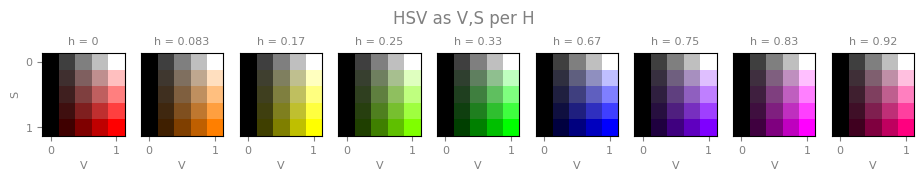

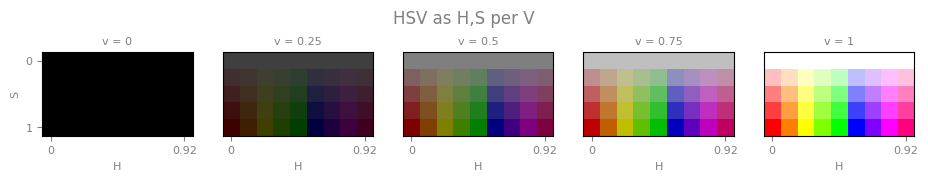

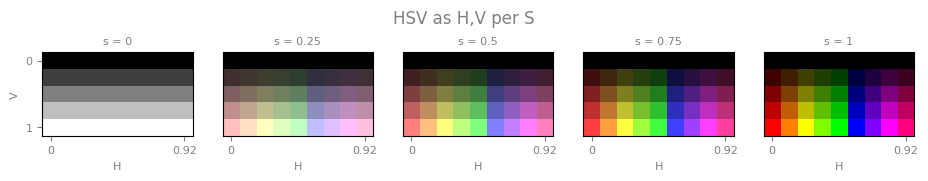

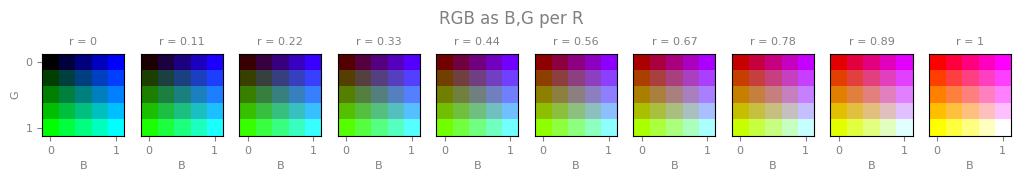

In [37]:
def isclose_cyclic(a: int | float | np.ndarray, b: int | float | np.ndarray, atol: float = 1e-8, period = 1.0) -> np.ndarray:
    """Check if two arrays are close in a cyclic manner (e.g., angles)."""
    return np.isclose(a, b, atol=atol) | np.isclose(a + period, b, atol=atol) | np.isclose(a - period, b, atol=atol)

red = 0/6
yellow = 1/6
green = 2/6
cyan = 3/6
blue = 4/6
magenta = 5/6

all_hues = np.arange(0, 1, 1/12)
holdout = isclose_cyclic(all_hues, cyan, atol=1/12 + 1e-8)

hsv_cube = ColorCube.from_hsv(
    all_hues[~holdout],
    np.linspace(0, 1, 5),
    np.linspace(0, 1, 5),
)

plot_colors(hsv_cube)
plot_colors(hsv_cube.permute('vsh'))
plot_colors(hsv_cube.permute('svh'))

rgb_cube = ColorCube.from_rgb(
    np.linspace(0, 1, 10),
    np.linspace(0, 1, 5),
    np.linspace(0, 1, 5),
)
plot_colors(rgb_cube)